In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [31]:
df = pd.read_csv("stores_sales_forecasting.csv", encoding='latin1')

In [32]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [33]:
print(df.dtypes)

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date                object
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object


In [34]:
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='ME'))['Sales'].sum()

print(monthly_sales.head())

Order Date
2014-01-31     6242.525
2014-02-28     1839.658
2014-03-31    14573.956
2014-04-30     7944.837
2014-05-31     6912.787
Freq: ME, Name: Sales, dtype: float64


In [35]:
weekly_sales = df.groupby(pd.Grouper(key='Order Date', freq='W'))['Sales'].sum()

print(weekly_sales.head())

Order Date
2014-01-12    2712.428
2014-01-19    1250.473
2014-01-26    1655.958
2014-02-02     623.666
2014-02-09      14.560
Freq: W-SUN, Name: Sales, dtype: float64


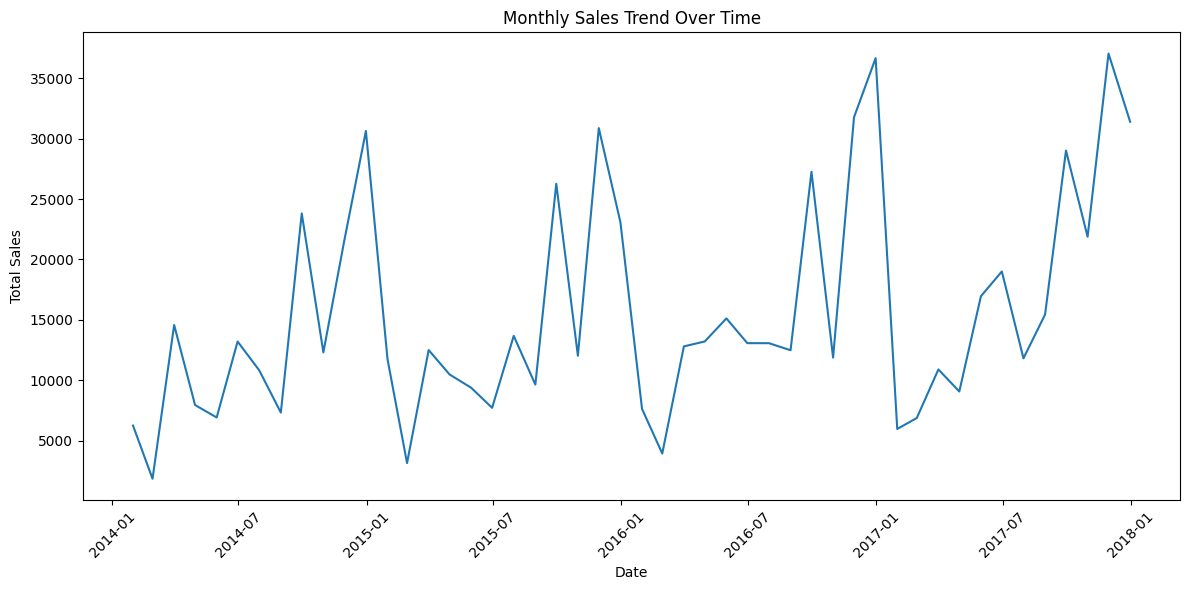

In [36]:
# Plot sales trend over time

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Monthly Sales Trend Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

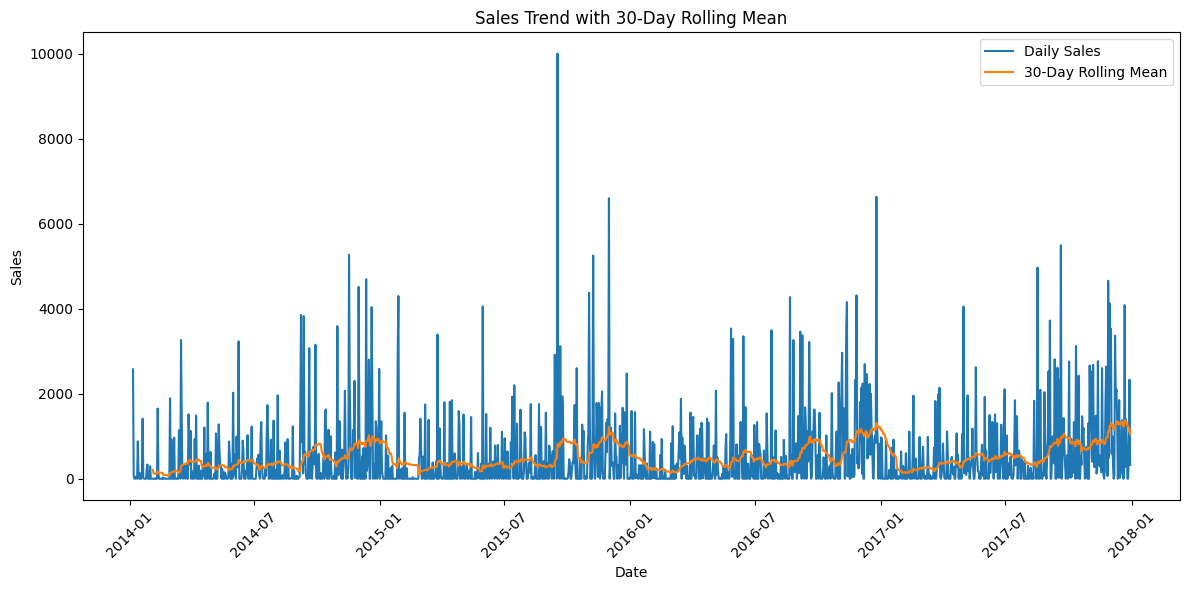

In [37]:
daily_sales = df.groupby(pd.Grouper(key='Order Date', freq='D'))['Sales'].sum()
rolling_mean_30 = daily_sales.rolling(window=30).mean()

# Plot original sales and rolling mean
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales.values, label='Daily Sales')
plt.plot(rolling_mean_30.index, rolling_mean_30.values, label='30-Day Rolling Mean')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Trend with 30-Day Rolling Mean")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
split_date = '2016-12-31'

train = df.loc[:split_date]
test = df.loc[split_date:]

In [39]:
split_index = int(len(df) * 0.8)

train = df.iloc[:split_index]
test = df.iloc[split_index:]

In [40]:
train = df.iloc[:-90]
test = df.iloc[-90:]

In [41]:
print("Train range:", train.index.min(), "to", train.index.max())
print("Test range:", test.index.min(), "to", test.index.max())

Train range: 0 to 2030
Test range: 2031 to 2120


In [42]:
# Example: 30-day moving average
window = 30

# Calculate rolling mean on train
train_ma = train['Sales'].rolling(window=window).mean()

# Forecast: use last rolling mean value for all future steps
ma_forecast = [train_ma.iloc[-1]] * len(test)

In [43]:
ma_forecast = pd.Series(ma_forecast, index=test.index)

In [44]:
print(ma_forecast)

2031    446.89802
2032    446.89802
2033    446.89802
2034    446.89802
2035    446.89802
          ...    
2116    446.89802
2117    446.89802
2118    446.89802
2119    446.89802
2120    446.89802
Length: 90, dtype: float64


In [45]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(train['Sales'])
fit = model.fit()

ses_forecast = fit.forecast(len(test))

In [46]:
print(ses_forecast)

2031    342.888479
2032    342.888479
2033    342.888479
2034    342.888479
2035    342.888479
           ...    
2116    342.888479
2117    342.888479
2118    342.888479
2119    342.888479
2120    342.888479
Length: 90, dtype: float64


In [47]:
from statsmodels.tsa.api import ExponentialSmoothing

# Fit on full historical data
model = ExponentialSmoothing(
    df['Sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=12   # Use 7 if daily weekly seasonality
)

fit = model.fit()

In [48]:
next_forecast = fit.forecast(1)

print("Next Period Predicted Sales:", next_forecast.iloc[0])

Next Period Predicted Sales: 406.5405129914659


In [49]:
future_forecast = fit.forecast(30)

In [50]:
print(future_forecast)

2121    406.540513
2122    417.513463
2123    456.281467
2124    361.174306
2125    344.301450
2126    379.487139
2127    370.852406
2128    461.677629
2129    351.380132
2130    294.340457
2131    415.758222
2132    320.218339
2133    405.076471
2134    416.049421
2135    454.817425
2136    359.710265
2137    342.837409
2138    378.023097
2139    369.388365
2140    460.213587
2141    349.916090
2142    292.876415
2143    414.294180
2144    318.754297
2145    403.612429
2146    414.585379
2147    453.353383
2148    358.246223
2149    341.373367
2150    376.559055
dtype: float64


In [51]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['Sales'], ses_forecast)

print("MAE:", mae)

MAE: 402.97080490790324


In [52]:
mape = np.mean(np.abs((test['Sales'] - ses_forecast) / test['Sales'])) * 100

print("MAPE:", mape, "%")

MAPE: 577.9250634217559 %


In [53]:
forecast_df = future_forecast.reset_index()
forecast_df.columns = ['date', 'forecast_sales']

In [54]:
forecast_df.to_csv("forecast.csv", index=False)